## Importing Libraries

In [32]:
# IMPORTING LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


from joblib import dump



## NHanes data from 2017 - 2020

In [21]:
df = pd.read_csv('/Users/tobiasmadsen/Documents/UMich/MDST/NHANES/data_files/eda_data.csv')

# Column name cleaning
df.columns = df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')','')
df.rename(columns={'Body_Mass_Index_kg/m**2': 'BMI_Value'}, inplace=True)
df.rename(columns={'Past_12_Months_Frequency_of_Drinking_Alcoholic_Beverages': 'Past_12_Mo_Alco'}, inplace=True)
df.head()


,Doctor_Told_Diabetes,Meals_Outside,FastFood_Meals,Ready_Eat_Foods_30D,Frozen_Meals_30D,Gender,Age_Years,Race,Vigorous_work_activity,Walk_or_bicycle,Vigorous_recreational_activities,BMI_Value,Waist_Circumference_cm,Hip_Circumference_cm,Past_12_Mo_Alco
0,No,7.0,0.0,0.0,5.0,Female,29.0,Non-Hispanic Asian,No,No,Yes,37.8,117.9,126.1,1 to 2 times in the last year
1,No,2.0,2.0,0.0,0.0,Male,49.0,Non-Hispanic White,No,No,No,29.7,120.4,108.2,Never in the last year
2,No,2.0,2.0,0.0,7.0,Male,36.0,Non-Hispanic White,Yes,No,No,21.9,86.8,94.5,Never in the last year
3,Yes,0.0,2.0,0.0,0.0,Male,68.0,Other Race - Including Multi-Racial,Yes,Yes,No,30.2,109.6,107.8,2 times a week
4,No,1.0,1.0,1.0,8.0,Male,76.0,Non-Hispanic White,No,No,No,26.6,100.0,107.0,Never in the last year


In [22]:
# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Doctor_Told_Diabetes'])

# First, separate your target variable from the features
X = df.drop('Doctor_Told_Diabetes', axis=1)  # These are your features
y = df['Doctor_Told_Diabetes']  # This is your target variable


# Define the ordinal categories and their order
ordinal_categories = [
    ['Yes', 'No'],      # for 'Vigorous_work_activity'
    ['Yes', 'No'],      # for 'Walk_or_bicycle'
    ['Yes', 'No'],      # for 'Vigorous_recreational_activities'
    ['Every day', 'Nearly every day', '3 to 4 times a week', '2 times a week',
     'Once a week', '2 to 3 times a month', 'Once a month',
     '7 to 11 times in the last year', '3 to 6 times in the last year',
     '1 to 2 times in the last year', 'Never in the last year']     # for 'Past_12_Mo_Alco'
]

# Define the names of the ordinal columns
ordinal_columns = ['Vigorous_work_activity', 'Walk_or_bicycle', 'Vigorous_recreational_activities', 'Past_12_Mo_Alco']

# Initialize the OrdinalEncoder with the defined categories
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)

# Separate the features dataframe into numerical, categorical, and ordinal
numerical_features = ['Meals_Outside', 'FastFood_Meals', 'Ready_Eat_Foods_30D', 'Frozen_Meals_30D', 'Age_Years', 'BMI_Value', 'Waist_Circumference_cm', 'Hip_Circumference_cm']
categorical_features = ['Gender', 'Race']

# Create transformers for each type of data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', ordinal_encoder)
])

# Combine transformations into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_columns)
    ])

# Apply the preprocessing to the features DataFrame 'X'
X_cleaned = preprocessor.fit_transform(X)


# Save the preprocessor
dump(preprocessor, 'preprocessor.joblib')

['preprocessor.joblib']

In [24]:
# Get feature names for the one-hot encoded categorical features
onehot_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Get feature names for ordinal features
# As ordinal features are not transformed into multiple columns, we can use the original column names
ordinal_features = ordinal_columns

# Combine numerical, one-hot encoded, and ordinal feature names
all_features = numerical_features + list(onehot_features) + ordinal_features

# Create the DataFrame
X_cleaned_df = pd.DataFrame(X_cleaned, columns=all_features)

# Add the target variable back into the DataFrame
X_cleaned_df['Doctor_Told_Diabetes'] = y_encoded

# Display the first few rows of the DataFrame
X_cleaned_df.head()

,Meals_Outside,FastFood_Meals,Ready_Eat_Foods_30D,Frozen_Meals_30D,Age_Years,BMI_Value,Waist_Circumference_cm,Hip_Circumference_cm,Gender_Female,Gender_Male,...,Race_Non-Hispanic Asian,Race_Non-Hispanic Black,Race_Non-Hispanic White,Race_Other Hispanic,Race_Other Race - Including Multi-Racial,Vigorous_work_activity,Walk_or_bicycle,Vigorous_recreational_activities,Past_12_Mo_Alco,Doctor_Told_Diabetes
0,0.966148,-0.873495,-0.392248,0.424702,-1.107897,1.050088,1.039825,1.314354,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,9.0,0
1,-0.345118,-0.050587,-0.392248,-0.374988,-0.023946,-0.024931,1.188189,0.068197,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,10.0,0
2,-0.345118,-0.050587,-0.392248,0.744578,-0.728514,-1.060135,-0.805828,-0.885566,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,10.0,0
3,-0.869624,-0.050587,-0.392248,-0.374988,1.005807,0.041428,0.547255,0.040350,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1
4,-0.607371,-0.462041,-0.200632,0.904517,1.439388,-0.436358,-0.022464,-0.015344,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,10.0,0


## Prep

### Train Test Split

In [25]:
# Split the data into X (features) and y (target)
X = X_cleaned_df.drop('Doctor_Told_Diabetes', axis=1)
y = X_cleaned_df['Doctor_Told_Diabetes']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)


### SMOTE

In [26]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## Logistic Regression

Accuracy: 0.7100558659217877
              precision    recall  f1-score   support

           0       0.94      0.70      0.80      1499
           1       0.33      0.77      0.46       291

    accuracy                           0.71      1790
   macro avg       0.63      0.73      0.63      1790
weighted avg       0.84      0.71      0.75      1790

                                     Feature  Coefficient
6                     Waist_Circumference_cm     1.069310
4                                  Age_Years     1.065975
11                   Race_Non-Hispanic Asian     0.557255
18          Vigorous_recreational_activities     0.533074
5                                  BMI_Value     0.472976
16                    Vigorous_work_activity     0.222222
10                     Race_Mexican American     0.142502
12                   Race_Non-Hispanic Black     0.119633
19                           Past_12_Mo_Alco     0.067635
1                             FastFood_Meals     0.052886
17    

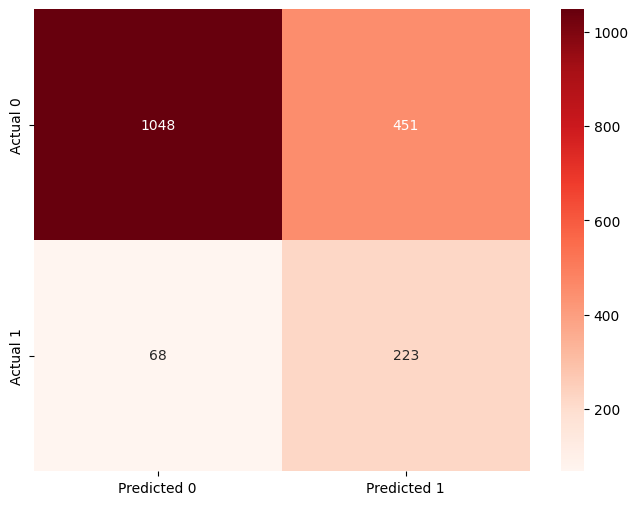

['logistic_regression_model.joblib']

In [27]:
# Initialize logistic regression model
logreg = LogisticRegression(max_iter=10000)

# Fit the model to the training data
logreg.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred = logreg.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

coefficients = logreg.coef_[0]
features = X.columns

coeff_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

sorted_coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)


print(sorted_coeff_df)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally, visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.show()

# Save the logistic regression model
dump(logreg, 'logistic_regression_model.joblib')


## Decision Tree

Decision Tree Accuracy: 0.7743
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1499
           1       0.32      0.35      0.33       291

    accuracy                           0.77      1790
   macro avg       0.60      0.60      0.60      1790
weighted avg       0.78      0.77      0.78      1790



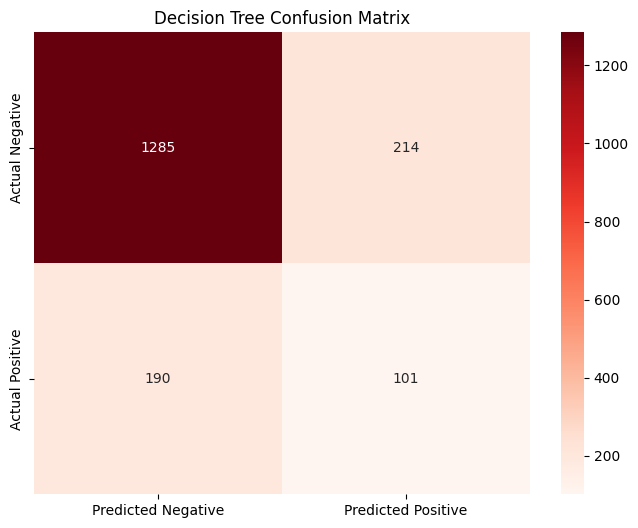

In [28]:
# Initialize decision tree model
dtree = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
dtree.fit(X_train, y_train)

# Predict on test data using decision tree
y_pred_tree = dtree.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred_tree)
print(f"Decision Tree Accuracy: {accuracy:.4f}")

# Print a detailed classification report
print(classification_report(y_test, y_pred_tree))

#
# plt.figure(figsize=(30,15))
# plot_tree(dtree, filled=True, feature_names=list(X.columns), class_names=['No Diabetes', 'Diabetes'], max_depth=3)
# plt.show()

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_tree)

# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Decision Tree Confusion Matrix')
plt.show()

## Random Forrest

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END max_depth=10, min_sa

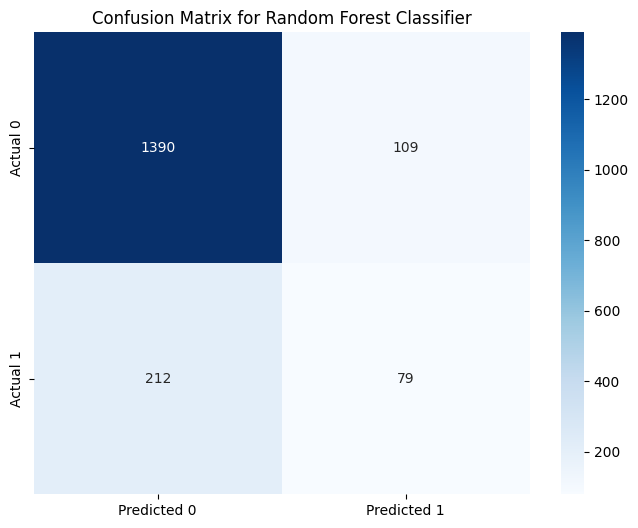

In [35]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a base model
rf = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train_smote, y_train_smote)

print("Best Parameters:", grid_search.best_params_)


# Predict on test data using random forest
y_pred_rf = grid_search.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy:.4f}")

# Print a detailed classification report
print(classification_report(y_test, y_pred_rf))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data
knn.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_knn = knn.predict(X_test_scaled)

# Evaluate the model
print("KNN Model Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

# Generate and display the confusion matrix for KNN model
cm_knn = confusion_matrix(y_test, y_pred_knn)
print("KNN Model Confusion Matrix:")
print(cm_knn)

# Optionally, visualize the confusion matrix of the KNN model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='g', cmap='Greens', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix for KNN Model")
plt.show()


### GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid: number of neighbors
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize a KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict using the best model
best_knn = grid_search.best_estimator_
y_pred_best_knn = best_knn.predict(X_test_scaled)

# Evaluate the best model
print("Accuracy of Best KNN Model:", accuracy_score(y_test, y_pred_best_knn))
print(classification_report(y_test, y_pred_best_knn))


## SVM

In [ ]:
from sklearn.svm import SVC

# Initialize the SVM model
svm_model = SVC(kernel="rbf", class_weight="balanced") 

# Fit the model to the training data
svm_model.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate the model
print("SVM Model Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# Generate and display the confusion matrix for SVM model
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("SVM Model Confusion Matrix:")
print(cm_svm)

# Optionally, visualize the confusion matrix of the SVM model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix for SVM Model")
plt.show()


## Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


In [ ]:

model = Sequential()

# Input layer
model.add(Dense(64, activation='relu', input_shape=(X_train_smote.shape[1],)))
model.add(Dropout(0.3))  # 30% dropout

# Hidden layer 1
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # 30% dropout

# Hidden layer 2
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))  # 30% dropout

# Hidden layer 3
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))  # 30% dropout

# Output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # stops after 5 epochs of no improvement

history = model.fit(
    X_train_smote, y_train_smote, 
    epochs=50,  # increased number of epochs 
    batch_size=64,  # increased batch size for faster computation
    validation_split=0.2,
    callbacks=[early_stopping]  # using the early stopping callback
)

loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


In [ ]:
# Predicting the Test set results
y_pred_proba = model.predict(X_test_scaled)
y_pred_class = (y_pred_proba > 0.5).astype("int32")  # Convert probabilities to class labels using 0.5 as a threshold

# Generate classification report
print(classification_report(y_test, y_pred_class))

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)

# Visualizing the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative (0)', 'Positive (1)'], 
            yticklabels=['Negative (0)', 'Positive (1)'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## GuassianNB

In [ ]:

from sklearn.naive_bayes import GaussianNB

# Initialize the Gaussian Naive Bayes model
gnb = GaussianNB()

# Fit the model to your training data
gnb.fit(X_train_smote, y_train_smote)

# Predict on your test data
y_pred_gnb = gnb.predict(X_test_scaled)

# Evaluate the performance
print("Classification Report for Gaussian Naive Bayes:\n")
print(classification_report(y_test, y_pred_gnb))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_gnb))


## Stacked model

In [ ]:
# Predictions from traditional models on the training set
train_pred_logreg = logreg.predict_proba(X_train_smote)[:, 1]
train_pred_knn = knn.predict_proba(X_train_smote)[:, 1]
train_pred_svm = svm_model.decision_function(X_train_smote)
train_pred_rf = rf.predict_proba(X_train_smote)[:, 1]

# Predictions from the neural network on the training set
train_pred_nn = model.predict(X_train_smote).ravel()

# Stack all the predictions together
stacked_train_predictions = np.column_stack((train_pred_logreg, train_pred_knn, train_pred_svm, train_pred_rf, train_pred_nn))


In [ ]:
meta_model = LogisticRegression(max_iter=10000)
meta_model.fit(stacked_train_predictions, y_train_smote)


In [ ]:
# Predictions from traditional models on the test set
test_pred_logreg = logreg.predict_proba(X_test_scaled)[:, 1]
test_pred_knn = knn.predict_proba(X_test_scaled)[:, 1]
test_pred_svm = svm_model.decision_function(X_test_scaled)
test_pred_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Predictions from the neural network on the test set
test_pred_nn = model.predict(X_test_scaled).ravel()

# Stack all test predictions together
stacked_test_predictions = np.column_stack((test_pred_logreg, test_pred_knn, test_pred_svm, test_pred_rf, test_pred_nn))

# Final predictions from the meta-model
final_predictions = meta_model.predict(stacked_test_predictions)



In [ ]:
# Classification report for the meta_model
print("Classification Report for Meta Model:\n")
print(classification_report(y_test, final_predictions))

# Confusion matrix for the meta_model
conf_matrix = confusion_matrix(y_test, final_predictions)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Meta Model')
plt.show()

## 👨‍💻 ML MODEL FOR FIRST STREAMLIT VERSION

Below I will try to make a dumb machine learning model with only gender, hip circumference and moderate work activity as predictors.

Why? 
To make a basic Streamlit model that we can work more on when we have decided on the predictor values we will ask the user.
- this includes taking a string input and converting it into one of the numbers our model us using


In [ ]:
#columns_for_dumb_model = ["Doctor_Told_Diabetes", "Gender", "Hip Circumference (cm)", "Vigorous recreational activities"]
#df_3 = df_merged[columns_for_dumb_model]

#df_3.info()

In [ ]:
#for column in df_3.columns:
    #print(f"Unique values in {column}:")
    #print(df_3[column].unique())
    #print("-" * 50)  # Just to separate the output for better visibility


In [ ]:
# Split the data into X (features) and y (target)
#X = df_3.drop('Doctor_Told_Diabetes', axis=1)
#y = df_3['Doctor_Told_Diabetes']

# Split data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# Initialize logistic regression model
#logreg = LogisticRegression(max_iter=10000)

# Fit the model to the training data
#logreg.fit(X_train, y_train)

# Predict on test data
#y_pred = logreg.predict(X_test)

# Evaluate the model
#print("Accuracy:", accuracy_score(y_test, y_pred))
#print(classification_report(y_test, y_pred))

#coefficients = logreg.coef_[0]
#features = X.columns

#coeff_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

#sorted_coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)


#print(sorted_coeff_df)

In [ ]:
#X

In [ ]:
#X1 = np.array([[2., 172.8, 2.]])
#X1

In [ ]:
#y_pred = logreg.predict(X1)
#y_pred